# TDI Capstone Project: Jails Charge Classifier for US Prisons

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import sklearn
from sklearn import base
import spacy
import re
import numpy as np

from pprint import pprint as pp
from itertools import combinations

# State Jail Data

The data was provided by the non-profit company **Recidiviz**, who are building the first real-time, nation-wide jails database for the US. The data was pulled from BigQuery using the following query statement, modifying the WHERE statement as necessary to get the truth or missing data for a given state:


SELECT name, class, region FROM `recidiviz-123.census.charge` as charge <br>
LEFT JOIN `recidiviz-123.census.booking` as booking ON charge.booking_id = booking.booking_id <br>
LEFT JOIN `recidiviz-123.census.person` as person ON booking.person_id = person.person_id <br>
WHERE class IS NOT NULL AND region LIKE "us_ky%" <br>
ORDER BY region <br>


The data has the following columns: name (str), class (str), region (str). <br>

The region was kept for possible regional statistics if need be, but is not currently used to train the charge classifier (which is built on the state level)


In [7]:
charge_data_no_class = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/ky_missing_data.csv")

charge_data = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/ky_truth_data.csv")
charge_data.head()

,name,class,region
0,OPERATING ON SUS OR REV OPER LICENSE,MISDEMEANOR,us_ky_adair
1,FAILURE TO PRODUCE INSURANCE CARD,MISDEMEANOR,us_ky_adair
2,CONTEMPT OF COURT LIBEL/SLANDER RESISTANC TO ORDER,MISDEMEANOR,us_ky_adair
3,SERVING WARRANT (FOR OTHER POLICE AGENCY),PROBATION_VIOLATION,us_ky_adair
4,SERVING WARRANT (FOR OTHER POLICE AGENCY),PROBATION_VIOLATION,us_ky_adair


# Organize Data

In [8]:
from sklearn.model_selection import train_test_split

### count nan values per column and drop all rows with nan values
print("NaN counts per column:")
print(charge_data.isna().sum())
print("Dropping NaN's from data since only 1 instance")
charge_data.dropna(inplace=True)
print("Should be no NaN's left:")
print(charge_data.isna().sum())

### Will assume charge descriptions indepedent of region (FOR NOW)
charge_desc = charge_data.drop(['class', 'region'], axis=1).values
charge_class = charge_data['class'].values

NaN counts per column:
name      1
class     0
region    0
dtype: int64
Dropping NaN's from data since only 1 instance
Should be no NaN's left:
name      0
class     0
region    0
dtype: int64


# Charge Classifer

The **charge classifier** takes in a **charge description** and outputs a **charge class**

                  
i.e. In the state KY: **charge description** = "PUBLIC INTOXICATION-CONTROL SUB (EXCLUDES ALCOHOL)" --> **charge class** = MISDEMEANOR

> The ML model will take place in two steps:
1. NLP to vectorize the words in each charge description
2. ML classifier to take vectorized words as input and classify the charge description

**The charge classifier will be trained per state due to differences in the law:**
1. The possible charges can differ from state to state
2. The descriptions of the charges themselves (even equivalent ones) may vary
3. The charge classes will likely be different from state to state:
    * i.e. felony charge classes: https://www.criminaldefenselawyer.com/resources/criminal-defense/felony-offense/felony-classes-charges-penalties

### Charge Classifier Model Diagram

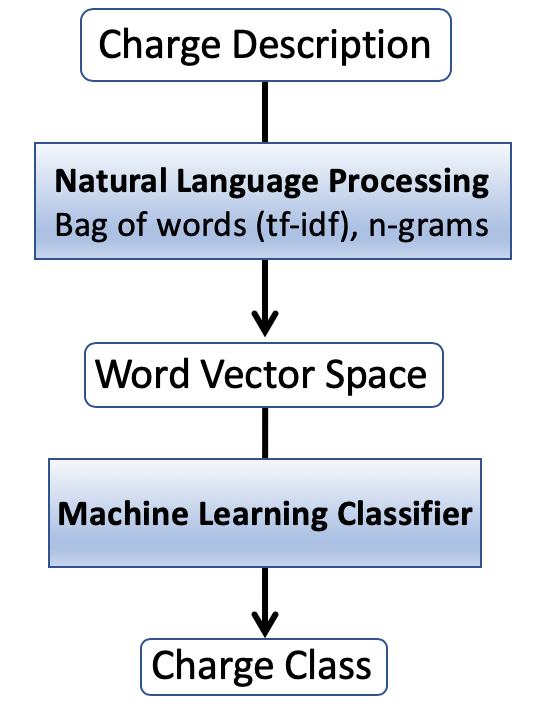

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("images/charge_classifier_model.png", width=240, height=240)

### Example of the charge classifier

Here we are given a human entered textual input, in this case for a drunk driving case in KY. In this specific case for a 1st offense, it is classified as a Misdemeanor in KY. 

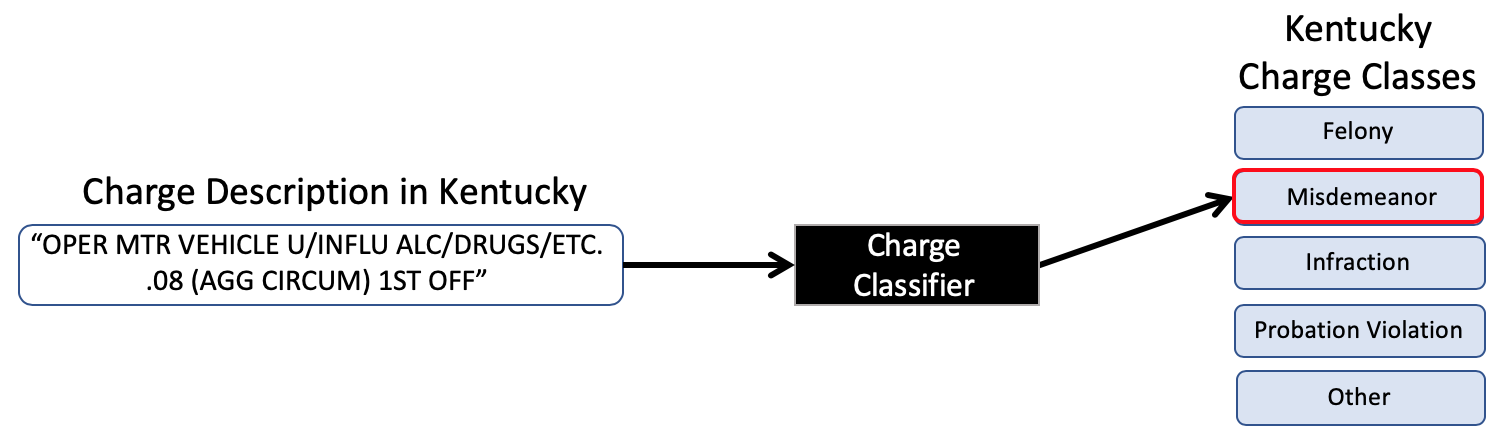

In [11]:
Image("images/charge_classifer_example.png", width=800, height=600)

### Imbalanced Classification Problem

Text(0, 0.5, 'log(count)')

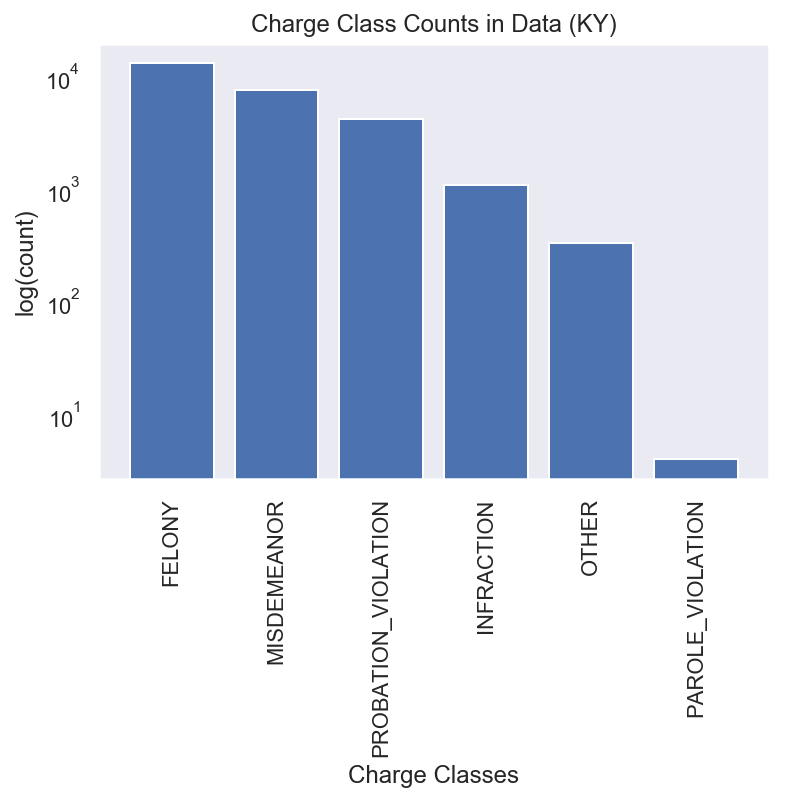

In [12]:
class_cnt_dict = charge_data['class'].value_counts().to_dict()
(x, y) = zip(*class_cnt_dict.items())
plt.bar(x,y)
plt.grid(b=None)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Charge Class Counts in Data (KY)')
plt.xlabel('Charge Classes')
plt.ylabel('log(count)')

Given that the database is growing in real time, instead of using methods such as SMOTE to syntheically increase data points for less represented classes I will re-run analysis at a future point when we can instead toss values from the larger classes to balance the data set.

## Motivation

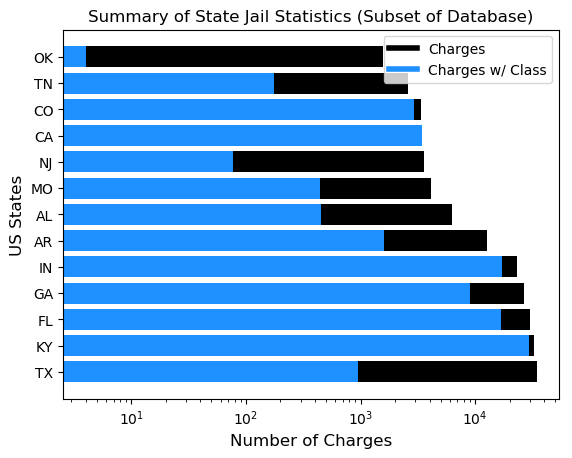

In [72]:
state_stats = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/state_stats.csv")
# print(len(state_stats))
# print(state_stats.head())

# print(state_stats['state'].values)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
states = state_stats['state'].values
states = [x.upper() for x in states]
y_pos = np.arange(len(states))
total_charges = state_stats['total_charges'].values
percents = state_stats['ave_has_charge_class']
# print(percents)
# error = np.random.rand(len(classifers))
num_cc = [tc*p/100.0 for (tc,p) in zip(total_charges, percents)]

data = [(st, t, cc) for (st, t, cc) in zip(states, total_charges, num_cc)]
data = sorted(data, key = lambda x: x[1])
# print(data[0:])

labels = [st for (st,t,cc) in data]
y1 = [t for (st,t,cc) in data]
y2 = [cc for (st,t,cc) in data]

ll = 5
ul = -1
labels = labels[ll:ul]
y1 = y1[ll:ul]
y2 = y2[ll:ul]
y_pos = y_pos[ll:ul]

ax.barh(y_pos, y1, align='center',
        color='black')
ax.barh(y_pos, y2, align='center',
        color='dodgerblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total Charges')
ax.set_title('Summary of State Jail Statistics (Subset of Database)')
ax.set_xscale('log')
ax.set_xlabel('Number of Charges', fontsize = 12)
ax.set_ylabel('US States', fontsize = 12)

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=30)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='dodgerblue', lw=4)]

ax.legend(custom_lines, ['Charges', 'Charges w/ Class'])

plt.show()

# plt.savefig('state_charges_comparison.png', dpi=800)

### (In)completeness of jail data

The jail data is woefully incomplete, with many states severely lacking charge classes for individuals admitted to prison. But we cannot wait for policies to be enacted to hold jails across the United States to a higher standard of modern data electronic record keeping. The goal of this project is to use ML to predict these missing charge classes, which are the basic metric by which we can quantify how the criminal justice system operates. The United States has incarceration rates an order of magnitude larger than the majority of other countries in the world. The story of mass incarceration in the United States is in the data, and I can hope the story will be compelling enough to drive efforts to improve it. 

### End Users

There are a number of end users who could make use of this classifier and/or the data metrics provided to analyze the US prison system.

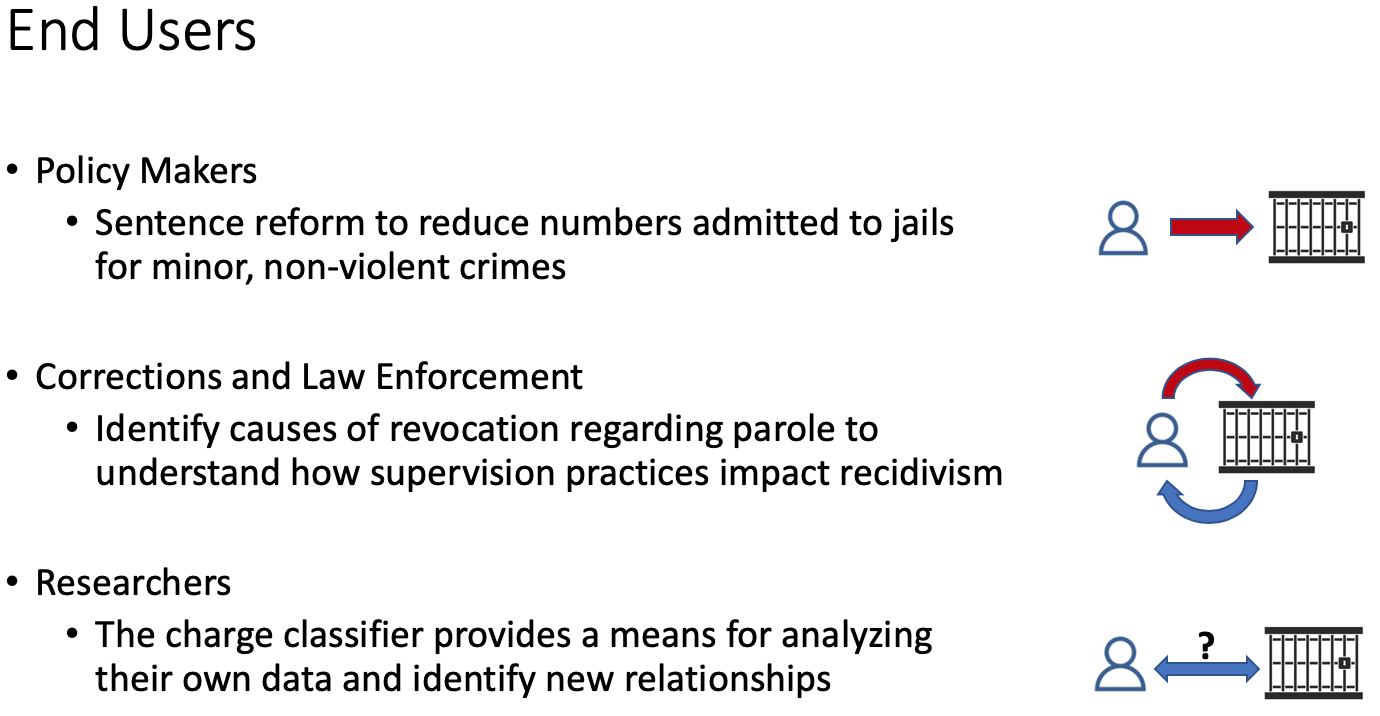

In [14]:
Image("images/end_users.png", width=800, height=600)

### Basic Statistics for Data in a Given State

In [15]:
print("Entries WITHOUT a charge class = {}".format(len(charge_data_no_class)))
print("Entries WITH a charge class = {}".format(len(charge_data)))
print("Percentage of charges having a charge description = {}".format(float(len(charge_data))/(len(charge_data)+len(charge_data_no_class))*100))
print("")
print("Number of unique charge classes: " + str(len(np.unique(charge_data['class']))))
print("Charge Classes = " + ', '.join(np.unique(charge_data['class'])))
print("")
print("Number of unique charge descriptions: " + str(len(np.unique(charge_data['name']))))


Entries WITHOUT a charge class = 1250
Entries WITH a charge class = 26114
Percentage of charges having a charge description = 95.43195439263266

Number of unique charge classes: 6
Charge Classes = FELONY, INFRACTION, MISDEMEANOR, OTHER, PAROLE_VIOLATION, PROBATION_VIOLATION

Number of unique charge descriptions: 1740


## Training Charge Classifier Model(s)

In [16]:
## cd = charge description
## cc = charge class

### Divide data into train and test (train:80%, test:20%)
cd_train, cd_test, cc_train, cc_test = train_test_split(charge_desc, charge_class, test_size=0.20, random_state=42)

print()
print("cd_train shape = {}".format(cd_train.shape))
print("cc_train shape = {}".format(cc_train.shape))
print()
print("cd_test shape = {}".format(cd_test.shape))
print("cc_test shape = {}".format(cc_test.shape))


cd_train shape = (20891, 1)
cc_train shape = (20891,)

cd_test shape = (5223, 1)
cc_test shape = (5223,)


# 1. Natural Language Processing

First step in the ML model is to vectorize the words in each charge description, for later classification.

**NLP Techniques (word vectorizing):**

> **Bag of Words (Primary approach)**
- Directly applicable to the charges description data being ingested, which is transformed into a matrix with rows (samples) being the charge descriptions (docs) and columns (features) having each unique word count.



> **Word2Vec (Secondary approach...Not applied here)**
- Gives relations between words (i.e. )...Best when have a large corpus of text to train on or a pre-trained model on language for a given field of interest. Possibly applicable here, but requires careful thought and implementation.

**Text Filtering/Parsing Methods:**

> **Handle Typos**:
- missing letters and spaces
    - Original: PUBLIC INTOXICATION-**CONTROLL** SU**B(E**XCLUDES ALCOHOL)	MISDEMEANOR
    - Clean:    PUBLIC INTOXICATION-**CONTROL** SUB (EXCLUDES ALCOHOL)	MISDEMEANOR
    - ...
    - **Strategies:**
        - Ignore typos initially
        - Use known packages to handle typos in the future

> **Handle Abbreviations**:

    - **w/ Abbreviations:** OPER MTR VEHICLE U/INFLU ALC/DRUGS/ETC. .08 (AGG CIRCUM) 1ST OFF	MISDEMEANOR
    - **w/ Expanded Text:** OPERATOR MOTOR VEHICLE UNDER/INFLUENCE ALCOHOL/DRUGS/ETC. .08 (AGGREVATING CIRCUMSTANCES) 1ST OFF	MISDEMEANOR
    - ...
    - **Strategies:**
        - Ignore and observe classifer efficiency
        - Scrape "Kentucky Legal Handbook for Patrol" and replace each abbreviation with full text
        - dict[abbr] = word(s)
        
> **Excluding "Stop words":**
- **Articles:** "a", "an", "the", etc.
        
> **Selectively Removing Punctuation:**
- By default, vectorizers in sklearn ignore all punctuation...but it may be useful to keep comparison operators ("=", ">" "<") in the text.
- **Special case** U/\\$1,000 is used to mean "under 1000 dollars)
    - built-in tokenizer interprets "U/\\$1,000" as "1" and "000"
- The forward slash "/"
    -U/\\$1000 = under \\$1000 OR B/W = between

# Bag of Words

> Bag of Words approach will use two steps:
1. Clean syntax in charge descriptions --> Special tokenizer
2. Tranform data into correct format **NumpyListofListsTransformer()**
3. Use the TfidfVectorizer to get word counts and then normalize them

## 2. ML Classifier

> There are many ML models that can be used for the charge classifer:
1. Naive Bayes
2. Support Vector Machine (SVM)
3. Logistical Regressor

I will proceed to train/test each, starting with the most simplistic in order to achieve a MVP.

**ML MODELS TRAINED**
1. Naive Bayes
2. SVM
3. Logsitic Regression

**BEST PERFORMER:** 
1. Logistical Regression


# Misc Definitions and Global Variables

In [17]:
from collections import Counter
def hasMinChargeClasses(cc_train, cc_test, total_classes):
    
    cc_train_counts = Counter(cc_train)
    cc_test_counts = Counter(cc_test)
    
    print(cc_train_counts)
    
    ### check if all classes represented
    if len(cc_train_counts) < total_classes or len(cc_test_counts) < total_classes:
        print('1')
        return False
    
    ### check if occurances for each class larger than threshold
    threshold = 50
    for cc, cnt in cc_train_counts.items():
        if cnt < threshold:
            print('2')
            return False
        
    for cc, cnt in cc_test_counts.items():
        if cnt < threshold:
            print('3')
            return False
        
    return True
    

In [18]:
from nltk.corpus import stopwords
def getStopWords():
    '''Returns list of stop words that will not be considered in 
       NLP vectorization.
       
       List of stop words generated from common articles of speech
       and those parts of speech recognized as articles in the
       charge descriptions using Spacy'''
    
    stopWords = list(stopwords.words('english'))
    
    for i, word in enumerate(stopWords[:]):
        stopWords[i] = re.sub('[\',]', '', word)
    
    return stopWords
    

In [19]:
def getSortedVocab():
    nplol = NumpyListofListsTransformer()
    count_vect = CountVectorizer()

    r1 = nplol.transform(cd_train)
    count_vect.fit(r1)

    sorted_vocab = sorted(count_vect.vocabulary_.items(), key=lambda kv: kv[1])
    return sorted_vocab

#### Special pre-processor and tokenzier to handle special syntax

In [20]:
import re
def my_preprocessor(s):
    s = re.sub('(\d+),(\d+)', '\g<1>\g<2>', s) ### remove commas from numbers
    s = re.sub('[\'/\$]', '', s) ### special case for U/$10000 syntax --> U10000
    return s.lower()

In [21]:
def get_tokenizer():
    return r"(?u)\b\w+\b"

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_single = CountVectorizer(ngram_range=(1,6), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())

sm = count_vect_single.fit_transform(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])

vocab = count_vect_single.vocabulary_
for word, index in vocab.items():
    print(word)

tbut
disp
others
500
u10000
tbut disp
disp others
others 500
500 u10000
tbut disp others
disp others 500
others 500 u10000
tbut disp others 500
disp others 500 u10000
tbut disp others 500 u10000


In [23]:
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
def getPrecisionRecall(y_pred, y_true):
    
    print("Precision = {}%".format(round(precision(y_true, y_pred, average='weighted')*100.0,2)))
    print("Recall = {}%".format(round(precision(y_true, y_pred, average='weighted')*100.0,2)))
    
    return

In [24]:
class NumpyListofListsTransformer(base.BaseEstimator, base.TransformerMixin):
    ''' Transforms list of lists containing charge descriptions into a numpy
        array of arrays, keeping charge descriptions invariant'''
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        np_charge_descs = []
        for cd_list in X:
            for cd in cd_list:
                np_charge_descs.append(cd)       
        
        result = np.array(np_charge_descs)
        
        return result

In [25]:
def missedClassifications(charge_desc, predicted, actual):
    ''' Takes in charge descriptions, predicted charge class and
        actual charge class.
        
        Returns a pandas dataframe for all mis-classifications, where
        columns are: 'Charge Description', 'Predicted Charge Class', 'Actual Charge Class' '''
    
    incorrect = []
    for c, p, a in zip(charge_desc, predicted, actual):
        if p != a:
            incorrect.append([c[0], p, a])

    return pd.DataFrame.from_records(incorrect, columns = ['Charge Description', 'Predicted Charge Class', 'Actual Charge Class'])

In [26]:
def missedClassificationCounts(df_missed_classifications):
    '''Takes in a pandas dataframe of missed classifications.
    
       Returns the same dataframe, for each unique Charge Description,
       with an additional 'counts' column, sorted in descending order by 'counts' '''
    
    mc_base_unique_cd_counts = df_missed_classifications.groupby('Charge Description')['Charge Description'].count().reset_index(name="count")

    mc_base_counts = pd.merge(df_missed_classifications,
                              mc_base_unique_cd_counts,
                              left_on='Charge Description',
                              right_on='Charge Description',
                              how='left')

    mc_base_counts.drop_duplicates(subset=None, keep='first', inplace=True)
    mc_base_counts.sort_values("count", axis=0, ascending=False, inplace=True, kind='quicksort') 
    
    return mc_base_counts

# Naive Bayes Model Efficiencies

# Model 1:
- No text filtering of charge descriptions
- No parameter tuning in NLP Vecotrizing
- No parameter tuning in ML Naive Bayes Classifier

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nplol = NumpyListofListsTransformer()
count_vect = CountVectorizer()
mnb = MultinomialNB()

pipe_base = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

pipe = pipe_base.fit(cd_train, cc_train)

predicted = pipe.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 91.59%

                     precision    recall  f1-score   support

             FELONY       0.92      0.94      0.93      2571
         INFRACTION       0.86      0.98      0.92       212
        MISDEMEANOR       0.96      0.85      0.90      1543
              OTHER       0.42      0.45      0.44        62
   PAROLE_VIOLATION       0.00      0.00      0.00         0
PROBATION_VIOLATION       0.89      0.98      0.93       835

          micro avg       0.92      0.92      0.92      5223
          macro avg       0.68      0.70      0.69      5223
       weighted avg       0.92      0.92      0.92      5223



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Model 1a: No surprise that TF/IDF had virtually no impact
- No text filtering of charge descriptions
- **NLP Vecotrizing normalizing word count (TF/IDF)**
- No parameter tuning in ML Naive Bayes Classifier

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nplol = NumpyListofListsTransformer()
tfidf = TfidfVectorizer()
mnb = MultinomialNB()


pipe = Pipeline([
        ('nplol', nplol),
        ('tfidf', tfidf),
        ('mnb', mnb),
])

bad_charge_clf = pipe.fit(cd_train, cc_train)

predicted = bad_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))


# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 91.35%

                     precision    recall  f1-score   support

             FELONY       0.91      0.96      0.93      2571
         INFRACTION       0.90      0.89      0.89       212
        MISDEMEANOR       0.94      0.83      0.88      1543
              OTHER       1.00      0.44      0.61        62
PROBATION_VIOLATION       0.90      0.96      0.93       835

          micro avg       0.91      0.91      0.91      5223
          macro avg       0.93      0.81      0.85      5223
       weighted avg       0.92      0.91      0.91      5223



# Model 1b: Including stop words seems to drop accuracy (insignificant)
- No text filtering of charge descriptions
- **NLP Vecotrizing contains generic list of "Stop Words"**
- No parameter tuning in ML Naive Bayes Classifier

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

nplol = NumpyListofListsTransformer()
count_vect = CountVectorizer(stop_words=getStopWords())
mnb = MultinomialNB()

pipe_base = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

charge_clf = pipe_base.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 90.94%

                     precision    recall  f1-score   support

             FELONY       0.91      0.95      0.93      2571
         INFRACTION       0.87      0.99      0.92       212
        MISDEMEANOR       0.96      0.82      0.88      1543
              OTHER       0.71      0.44      0.54        62
   PAROLE_VIOLATION       0.00      0.00      0.00         0
PROBATION_VIOLATION       0.87      0.97      0.92       835

          micro avg       0.91      0.91      0.91      5223
          macro avg       0.72      0.69      0.70      5223
       weighted avg       0.91      0.91      0.91      5223



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Model 1c:
- No text filtering of charge descriptions
- **NLP Vecotrizing using ngrams**
- No parameter tuning in ML Naive Bayes Classifier

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

nplol = NumpyListofListsTransformer()
count_vect = CountVectorizer(ngram_range=(2,6))
mnb = MultinomialNB()

pipe = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

charge_clf = pipe.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 95.79%

                     precision    recall  f1-score   support

             FELONY       0.97      0.97      0.97      2571
         INFRACTION       0.93      0.97      0.95       212
        MISDEMEANOR       0.98      0.94      0.96      1543
              OTHER       0.69      0.56      0.62        62
   PAROLE_VIOLATION       0.00      0.00      0.00         0
PROBATION_VIOLATION       0.91      0.98      0.94       835

          micro avg       0.96      0.96      0.96      5223
          macro avg       0.75      0.74      0.74      5223
       weighted avg       0.96      0.96      0.96      5223



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Model 1d:
- No text filtering of charge descriptions
- **NLP Vecotrizing using Stop Words and ngrams**
- No parameter tuning in ML Naive Bayes Classifier

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1
from sklearn.metrics import classification_report

nplol = NumpyListofListsTransformer()
count_vect = CountVectorizer(ngram_range=(1,6), stop_words=getStopWords())
mnb = MultinomialNB()

pipe = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

charge_clf = pipe.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)

#### unique classes in training data
# unique_classes = set(cc_train)
# charge_classes = (sorted(list(unique_classes))) 
# print(sorted(list(set(cc_test))))

print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))


# mc_base = missedClassifications(cd_test, predicted, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 95.58%

                     precision    recall  f1-score   support

             FELONY       0.97      0.96      0.97      2571
         INFRACTION       0.91      0.99      0.95       212
        MISDEMEANOR       0.97      0.95      0.96      1543
              OTHER       0.71      0.52      0.60        62
   PAROLE_VIOLATION       0.00      0.00      0.00         0
PROBATION_VIOLATION       0.90      0.98      0.94       835

          micro avg       0.96      0.96      0.96      5223
          macro avg       0.75      0.73      0.74      5223
       weighted avg       0.96      0.96      0.96      5223



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Model 1e: Optimal Params Found via GridsearchCV
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **Parameter tuning in ML Naive Bayes Classifier**

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection

nplol = NumpyListofListsTransformer()
# cct = CleanChargesTransformer()
ng_tfidf = TfidfVectorizer(stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
mnb = MultinomialNB()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('mnb', mnb),
])

param_grid = {
    'ng_tfidf__ngram_range': list(combinations(np.arange(1, 6, 1),2)),
    'mnb__alpha': np.arange(0.2, 2, 0.1)
}

gs = model_selection.GridSearchCV(
    pipe,
    param_grid,
    cv=2,
    n_jobs=4  # run each hyperparameter in one of two parallel jobs
)

nb_charge_clf = gs.fit(cd_train, cc_train)
print (gs.best_params_)

predicted = nb_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

{'mnb__alpha': 0.2, 'ng_tfidf__ngram_range': (1, 5)}
Accuracy = 96.44%

                     precision    recall  f1-score   support

             FELONY       0.99      0.97      0.98      2571
         INFRACTION       0.92      0.98      0.95       212
        MISDEMEANOR       0.97      0.97      0.97      1543
              OTHER       0.80      0.56      0.66        62
PROBATION_VIOLATION       0.91      0.97      0.94       835

          micro avg       0.96      0.96      0.96      5223
          macro avg       0.92      0.89      0.90      5223
       weighted avg       0.96      0.96      0.96      5223



# Model 2: SVM Classifier
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **No Parameter tuning in ML SVM classifier**

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

nplol = NumpyListofListsTransformer()
# cct = CleanChargesTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(2,5), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
# clf_svm = SGDClassifier()
clf_svm = SGDClassifier(loss='log')

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('clf_svm', clf_svm),
])

svm_charge_clf = pipe.fit(cd_train, cc_train)

predicted = svm_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy = 96.0%

                     precision    recall  f1-score   support

             FELONY       0.95      0.99      0.97      2571
         INFRACTION       0.95      0.89      0.92       212
        MISDEMEANOR       0.99      0.96      0.97      1543
              OTHER       1.00      0.42      0.59        62
PROBATION_VIOLATION       0.93      0.94      0.93       835

          micro avg       0.96      0.96      0.96      5223
          macro avg       0.97      0.84      0.88      5223
       weighted avg       0.96      0.96      0.96      5223



# Model 3: Logistic Regression
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **No Parameter tuning in ML Logistical Regression classifier**

In [44]:
from pprint import pprint as pp
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

######### GRID SEARCH FOR OPTIMAL PARAMS ##############

# nplol = NumpyListofListsTransformer()
# ng_tfidf = TfidfVectorizer(ngram_range=(1,5), stop_words=getStopWords())
# lreg = LogisticRegression()
# 
# pipe = Pipeline([('nplol', nplol),
#                  ('ng_tfidf', ng_tfidf),
#                  ('lreg', lreg),
# ])

# param_grid = {
#     'ng_tfidf__ngram_range': list(combinations(np.arange(1, 6, 1),2)),
#     'lreg__C': np.arange(0.1, 5, 0.2),
# }

# gs = model_selection.GridSearchCV(
#     pipe,
#     param_grid,
#     cv=2,
#     n_jobs=2  # run each hyperparameter in one of two parallel jobs
# )

# log_charge_clf = gs.fit(cd_train, cc_train)
# print (gs.best_params_)


########## USING OPTIMAL PARAMS FROM GRID SEARCH ############

nplol = NumpyListofListsTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
lreg = LogisticRegression(C=4.3)

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('lreg', lreg),
])

log_charge_clf = pipe.fit(cd_train, cc_train)

predicted = log_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))


### investigating vocab ###
# vocab = ng_tfidf.vocabulary_
# print(len(vocab))
# phrases = []
# for word, index in vocab.items():
#     phrases.append(word)
# s_phrases = sorted(phrases)
# print(s_phrases[-1000:])


/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy = 97.66%

                     precision    recall  f1-score   support

             FELONY       0.99      0.99      0.99      2571
         INFRACTION       0.96      0.96      0.96       212
        MISDEMEANOR       0.99      0.98      0.98      1543
              OTHER       1.00      0.56      0.72        62
PROBATION_VIOLATION       0.94      0.97      0.95       835

          micro avg       0.98      0.98      0.98      5223
          macro avg       0.97      0.89      0.92      5223
       weighted avg       0.98      0.98      0.98      5223



### Investigating Missed Classifications

In [45]:
mc = missedClassifications(cd_test, predicted, cc_test)
mc_counts = missedClassificationCounts(mc)
mc_counts.head()

,Charge Description,Predicted Charge Class,Actual Charge Class,count
11,SERVING BENCH WARRANT FOR COURT,PROBATION_VIOLATION,OTHER,12
29,FAILURE TO APPEAR,PROBATION_VIOLATION,OTHER,5
10,THEFT OF SERVICES,FELONY,MISDEMEANOR,4
4,PROBATION VIOLATION (FOR FELONY OFFENSE),PROBATION_VIOLATION,OTHER,4
28,PROBATION VIOLATION (FOR TECHNICAL VIOLATION),PROBATION_VIOLATION,OTHER,2


The 2 charge classes below (next cell for analysis) are predicted to be felonies, however:

1. TBUT OR DISP ALL OTHERS \\$500 OR MORE BUT U/\\$10,000 -> **Felony**
2. TBUT OR DISP ALL OTHERS U/$500 -> **Misdemeanor**

This occurs because there are more instances of 1. than 2. in the data and they have very similar charge descriptions. Without a custom tokenizer, "U/\\$10,000" gets parsed as "10" and "000". This is pretty meaningless. I correctly made a tokenizer that would parse "U/\\$10,000" as "U10000"; however, this was not enough to fix the above misclassification. 

In the future, I think monetary amounts need to be weighted more heavily to correctly differentiate this case and many others like it.

In [46]:
chrg_cls = log_charge_clf.classes_
print(chrg_cls)
print()

print('TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = \
{}'.format(log_charge_clf.predict(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])[0]))
print()
probs_1 = log_charge_clf.predict_proba(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])[0]
for x,y in zip(chrg_cls,probs_1):
    print(x,y)
    
print()
print("----------------------------")
print()

print('TBUT OR DISP ALL OTHERS U/$500, predicted class = \
{}'.format(log_charge_clf.predict(['TBUT OR DISP ALL OTHERS U/$500'])[0]))
print()
probs_2 = log_charge_clf.predict_proba(['TBUT OR DISP ALL OTHERS U/$500'])[0]
for x,y in zip(chrg_cls,probs_2):
    print(x,y)

['FELONY' 'INFRACTION' 'MISDEMEANOR' 'OTHER' 'PAROLE_VIOLATION'
 'PROBATION_VIOLATION']

TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = FELONY

FELONY 0.5572147366092611
INFRACTION 0.04256827243204011
MISDEMEANOR 0.3336154971020235
OTHER 0.0027642553965013016
PAROLE_VIOLATION 0.00032462635204998173
PROBATION_VIOLATION 0.06351261210812391

----------------------------

TBUT OR DISP ALL OTHERS U/$500, predicted class = FELONY

FELONY 0.5572147366092611
INFRACTION 0.04256827243204011
MISDEMEANOR 0.3336154971020235
OTHER 0.0027642553965013016
PAROLE_VIOLATION 0.00032462635204998173
PROBATION_VIOLATION 0.06351261210812391


# Model Accuracy

[0 1 2]


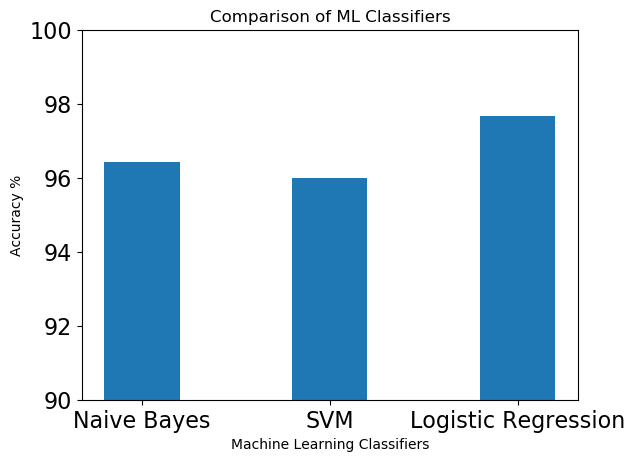

In [47]:
########### Model Accuracy ###############

plt.rcdefaults()
fig, ax = plt.subplots()

classifers = ('Naive Bayes', 'SVM', 'Logistic Regression')
x = np.arange(len(classifers))
print(x)
performance = [nb_charge_clf.score(cd_test, cc_test), svm_charge_clf.score(cd_test, cc_test), log_charge_clf.score(cd_test, cc_test)]
performance = [x*100 for x in performance]

plt.bar(x, performance, width=0.4, bottom=None, align='center', tick_label=classifers)
plt.xticks(x)
plt.ylim([90,100])
# plt.figure(figsize=(10,10))
# plt.rcParams.update({'font.size': 30})
plt.tick_params(labelsize=16)
plt.ylabel('Accuracy %')
plt.xlabel('Machine Learning Classifiers')
plt.title('Comparison of ML Classifiers')

plt.show()
# plt.savefig('classifer_comparison.png', dpi=800)

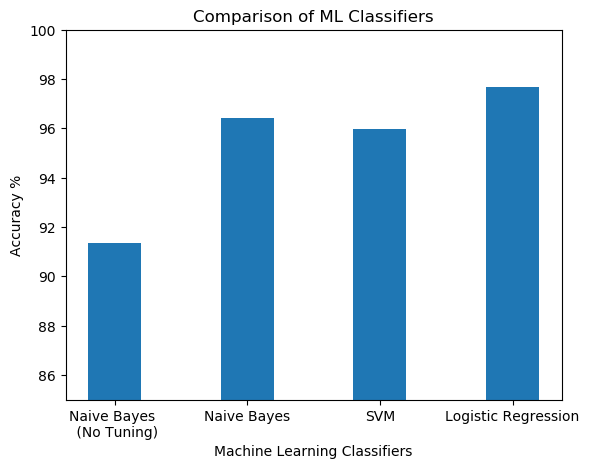

In [48]:
### 3) charge class (unique/counts)...shows unbalanced classes

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
classifers = ('Naive Bayes \n (No Tuning)', 'Naive Bayes', 'SVM', 'Logistic Regression')
x = np.arange(len(classifers))

performance = [bad_charge_clf.score(cd_test, cc_test), nb_charge_clf.score(cd_test, cc_test), svm_charge_clf.score(cd_test, cc_test), log_charge_clf.score(cd_test, cc_test)]
performance = [x*100 for x in performance]

plt.bar(x, performance, width=0.4, bottom=None, align='center', tick_label=classifers)
plt.xticks(x)
plt.ylim([85,100])
plt.ylabel('Accuracy %')
plt.xlabel('Machine Learning Classifiers')
plt.title('Comparison of ML Classifiers')

plt.show()
# plt.savefig('classifer_comparison.png', dpi=800)

# CONCLUSION

The models perform admirably, approaching 98% for the Logistic Regression. I do not doubt that with more time to appropriately search for optimal parameters, the SVM will likely become the most accurate model.

I am working with Recidiviz to implement this classifier and future improvements into their platform. The current goal is to use the classifier to create "filled tables" in their database with the following information:

1. Predicted Charge Class
2. Probability distribution for all charge classes, so someone viewing the table can make an informed decision about the classifier's performance in a given instance

The baseline goal is to achieve 99%. However, given this is a mixed classificaiton problem I believe optimizing precision and recall to 99% to be the ultimate goal. In this industry, it's very important to have high precision as to not misclassify a dangerous offense as something trivial or to misclassify something trivial as a more severe crime. Similar consequences would occur if we have poor recall.

I am confident this project will make a real world impact to the mentioned end users as the Recidiviz real-time US jails database gains more coverage and my ML charge classifier fills in the missing information with high confidence.

### Next Steps

1. Better NLP to improve the ML classifier, which can only be as good as the word/phrase parsing/vectorizing allows it to be
    > 1. Future efforts to nail down specific syntax regarding state-by-state jail charge descriptions
    > 2. Tackle abbreviations (should be the same as the full word, unless it's common to say "veh" for one charge class and "vehicle" for another, for example
    c. Tackle typos (there are many different representations of self-similar words that have typos)
2. An ensemble model to improve ML classification:
    > 1. If the softmax class probability of the first model is too close to other class probabilities, try classifiying the charge using an alternative model